## Image Based Steganography Using Constrained Least_Squares

### Importing necessary libraries

In [6]:
import os
import math
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

### Initialize necessary functions

In [10]:
def Read_Image_File(folder_name):
    """
    This function reads an image file from a given folder and normalizes its pixel values.
    
    Parameters:
    folder_name (str): The path to the image file. It should include the file name and its extension.
    
    Returns:
    tuple: A tuple containing the original image and the normalized image. If an error occurs during reading or normalization, a warning message is printed and only the original image is returned.
    """
    
    # Try to execute the following block of code
    try:
        # Open the image file at the given path
        image = Image.open(folder_name)
        
        # Normalize the pixel values of the image to the range [0, 1]
        # This is done by subtracting the minimum pixel value from all pixel values and then dividing by the range of pixel values
        normalisedImage = ((image - np.min(image)) / (np.max(image) - np.min(image)))
        
        # Convert the normalized image to a numpy array
        normalisedImage = np.asarray(normalisedImage)
        
    # If an error occurs during the execution of the above block of code
    except:
        # Print a warning message indicating the file that caused the error
        print(f"WARNING: Excluding '{folder_name}'...")
        
        # Return only the original image
        return image, None

    # If no error occurs, return both the original and the normalized image
    return image, normalisedImage


def GetImages(folder_name):
    """
    This function reads all image files from a given folder, normalizes their pixel values, 
    and returns a pandas DataFrame containing the file names, original images, and normalized images.
    
    Parameters:
    folder_name (str): The path to the folder containing the image files.
    
    Returns:
    DataFrame: A pandas DataFrame with three columns: 'name' for the file names, 
    'image' for the original images, and 'normalizedImage' for the normalized images. If the folder does not exist, an error message is printed and None is returned.
    """
    
    # Check if the given folder name corresponds to an existing directory
    if not os.path.isdir(folder_name):
        # If not, print an error message and return None
        print(f"Error: '{folder_name}' is not a valid folder.")
        return
    
    # Initialize lists to store the file names, original images, and normalized images
    name, image, normalisedImage = [], [], [] 
    
    # Loop over all files in the given directory
    for file_name in os.listdir(folder_name): 
        # If the file is an image (i.e., its name ends with a common image file extension)
        if file_name.endswith((".jpg", ".jpeg", ".png", ".gif")):
            # Read the image file and normalize its pixel values
            img, normImg = Read_Image_File(f"{folder_name}/{file_name}")
            
            # Append the file name to the list of file names
            name.append(file_name)
            
            # Append the original image to the list of original images
            image.append(img)
            
            # Append the normalized image to the list of normalized images
            normalisedImage.append(normImg)
            
    # Create a pandas DataFrame from the lists of file names, original images, and normalized images
    df = pd.DataFrame({'name' : name, 'image' : image, 'normalizedImage' : normalisedImage})
    
    # Return the DataFrame
    return df


def Steganography(fo_path, imgData):
    """
    This function implements a simple steganography algorithm on an image. 
    It first creates a secret message as a random binary vector, 
    then hides this message in the image by slightly modifying its pixel values. 
    The function also visualizes the original and modified images, 
    and calculates the error rate of the message decoding process.
    
    Parameters:
    fo_path (str): The path to the folder where the image file is located.
    imgData (np.array): The original image data as a 2D numpy array.
    
    Returns:
    None. The function only prints and plots information.
    """
    
    # Print the shape of the image
    print(f'Image Shape: {imgData.shape} \n')

    # Create a secret message as a random binary vector
    k0 = 100
    np.random.seed(1968)
    s = np.random.choice([-1, 1], size = k0).reshape(-1, 1)
    k = s.shape[0]
    print(f'Vector s: k = {k}')  

    # Flatten the image data into a 1D vector
    x = imgData.flatten().reshape(-1, 1)
    n =  x.shape[0]
    print(f'Vector x: n = {n}')
    print()

    # Define a random matrix D
    np.random.seed(1968)
    D = np.random.uniform(-1, 1, (k, n))
    print(f'Matrix D: (k x n) = {D.shape}')
    print(f'Matrix D: Rank = {np.linalg.matrix_rank(D)}')

    # Calculate the pseudo-inverse of D
    Ddagger = np.linalg.pinv(D)

    # Define a range of alpha values
    a = (10.0)**(np.arange(-4, 6, 1))
    
    # Initialize a figure for plotting
    fig, ax = plt.subplots(2, 5, figsize=(15, 10))  

    # Loop over all alpha values
    for i, axs in enumerate(ax.reshape(-1)):
        # If this is the first iteration, plot the original image
        if i == 0:
            axs.imshow(imgData,  cmap='gray')
            axs.set_title('Initial Image')
        else:
            # Calculate the modified image data
            z = Ddagger.dot(a[i-1]*s - D.dot(x))
            xPLUSz = pd.Series((x+z).flatten()).apply(lambda x: 0 if x < 0 else 1 if x > 1 else x).to_numpy().reshape(-1,1)

            # Decode the secret message from the modified image data
            y = D.dot(xPLUSz)
            s_hat = np.sign(y)

            # Calculate the error rate of the decoding process
            error = ((s_hat != s).sum()/(s_hat.shape[0]))*100

            # Plot the modified image and the error rate
            axs.imshow(xPLUSz.reshape(imgData.shape),  cmap='gray')
            axs.set_title(f"$\\alpha$ = {a[i-1]:.3f}\nError Rate: {error:.2f}%")

    # Adjust the layout of the figure and display it
    fig.tight_layout()
    plt.show() 

    
    
def Simulate_Steganography(folder_name):
    """
    This function simulates the steganography process on all image files in a given folder. 
    It first reads and normalizes the images, then applies the steganography algorithm on each image, 
    and finally visualizes the original and modified images and calculates the error rate of the message decoding process.
    
    Parameters:
    folder_name (str): The path to the folder containing the image files.
    
    Returns:
    None. The function only prints and plots information.
    """
    
    # Read and normalize all image files in the given folder
    images = GetImages(folder_name)

    # Loop over all images
    for i in range(len(images)):
        # Print the index and name of the current image
        print("Image : ", i+1)
        print(f"Image Name : {images['name'][i]}")
        print()
        
        # Apply the steganography algorithm on the current image and print the results
        Steganography(folder_name, images['normalizedImage'][i])
        
        print("\n\n")

### Experimentation 

Image :  1
Image Name : Cameraman.jpg

Image Shape: (512, 512) 

Vector s: k = 100
Vector x: n = 262144

Matrix D: (k x n) = (100, 262144)
Matrix D: Rank = 100


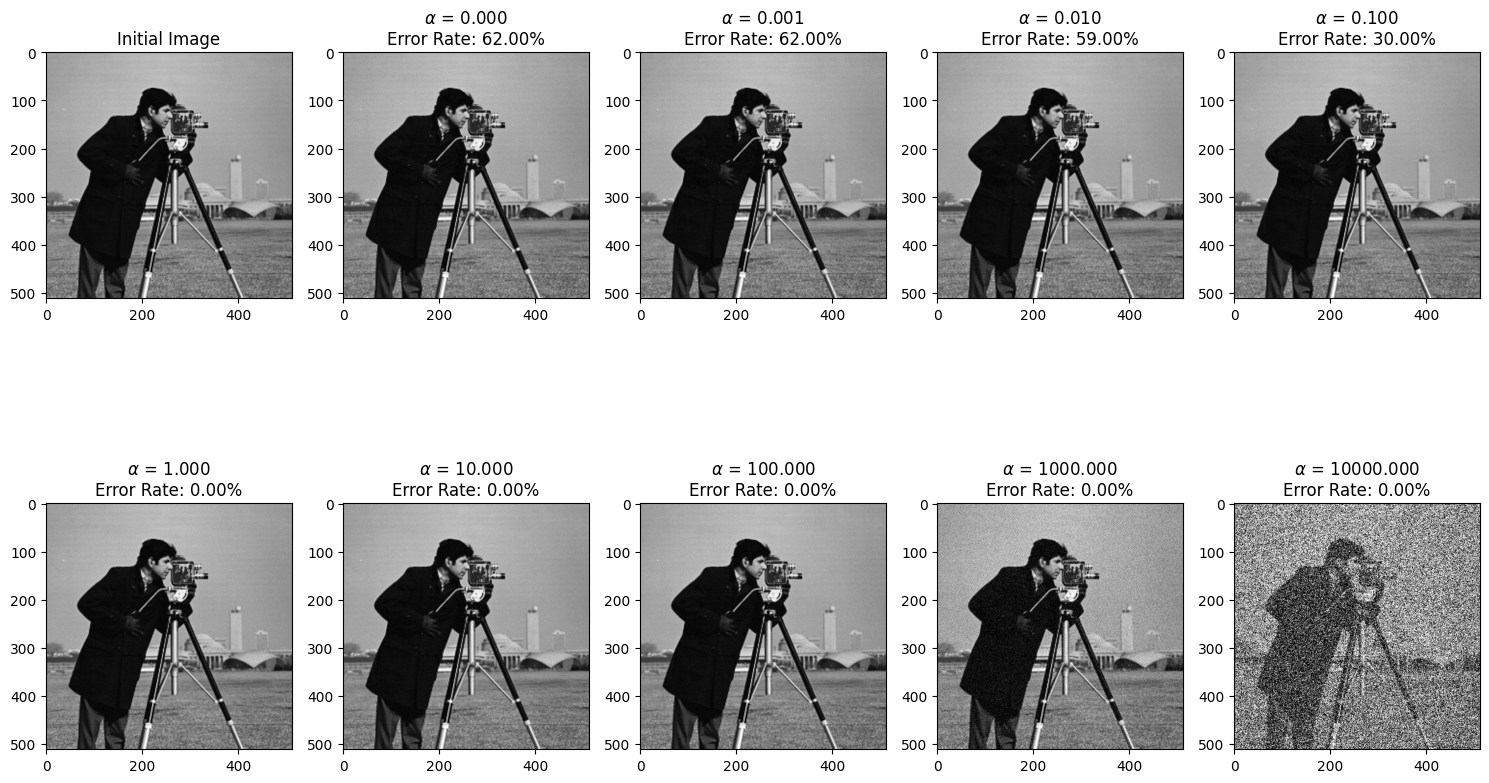




Image :  2
Image Name : Lena.jpg

Image Shape: (567, 567) 

Vector s: k = 100
Vector x: n = 321489

Matrix D: (k x n) = (100, 321489)
Matrix D: Rank = 100


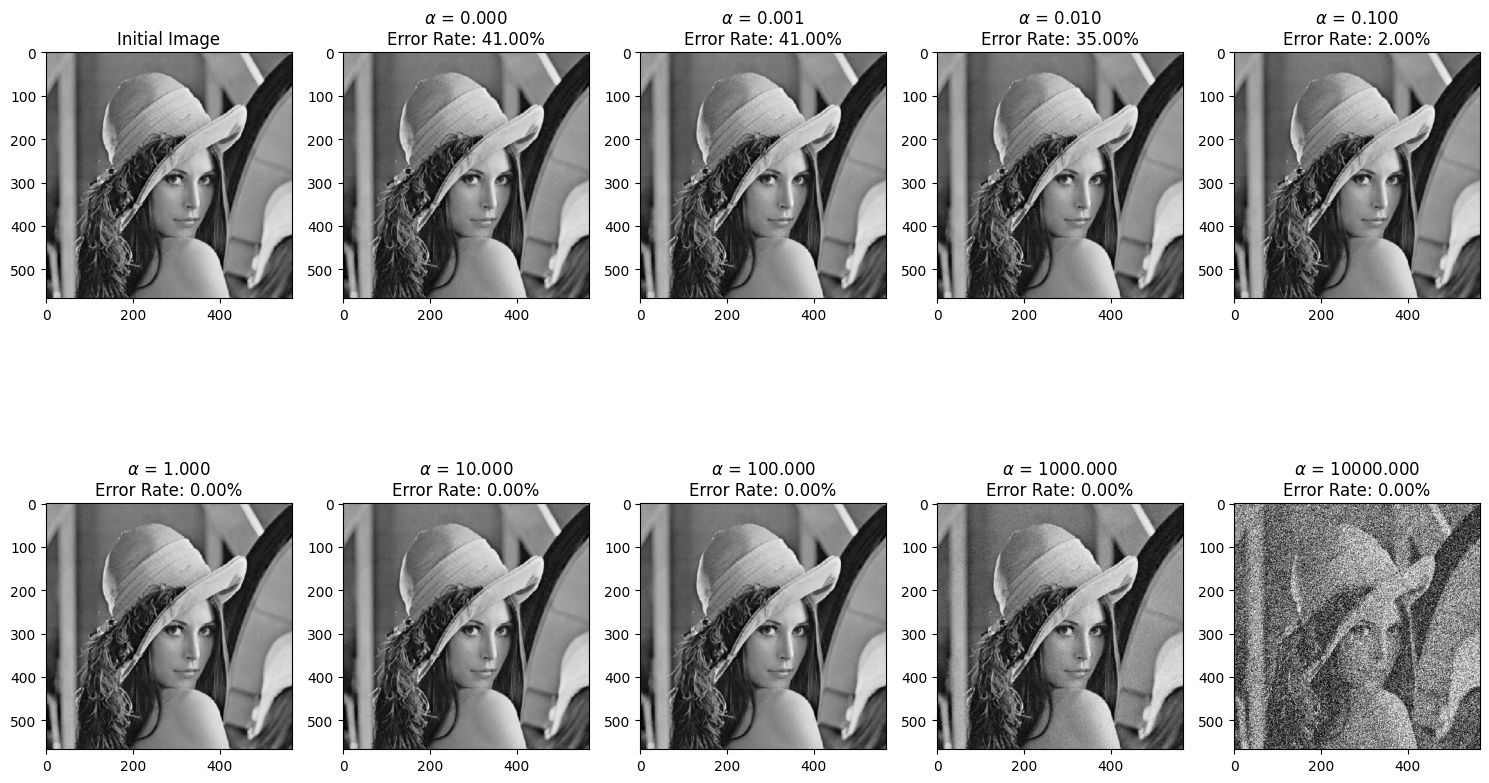

In [11]:
if __name__ == "__main__":
  
    # Define the folder where the images for the Steganography are
    folder_name = 'images'

    # Use the steganography method on the test images
    Simulate_Steganography(folder_name)